In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=f1e5b5bedda3e2578890be92d50da9d3c6ff98bbfe4addc78c6c26e2a044cc0c
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 9 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package 

In [2]:
import pyspark
import pyspark.sql as pyspark_sql
import pyspark.sql.types as pyspark_types
import pyspark.sql.functions as pyspark_functions
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col
import json

In [3]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark_sql.SparkSession.builder.getOrCreate()

Question 1:

In [ ]:
#a
df_bombing_operations = spark.read.json('Bombing_Operations.json')

missions_by_country = df_bombing_operations.groupBy('ContryFlyingMission').count()
missions_by_country.show()

+--------------------+-----+
| ContryFlyingMission|count|
+--------------------+-----+
|     VIETNAM (SOUTH)| 6392|
|       KOREA (SOUTH)|  333|
|UNITED STATES OF ...|16303|
|           AUSTRALIA|  151|
|                LAOS|  449|
+--------------------+-----+



In [ ]:
#b
df_bombing_operations = spark.read.json('Bombing_Operations.json')
df_bombing_operations.createOrReplaceTempView("bombing_operations")

query = """
        SELECT ContryFlyingMission, COUNT(*) as num_missions
        FROM bombing_operations
        GROUP BY ContryFlyingMission
"""

sql_df = spark.sql(query)
sql_df.show()

+--------------------+------------+
| ContryFlyingMission|num_missions|
+--------------------+------------+
|     VIETNAM (SOUTH)|       10285|
|       KOREA (SOUTH)|         525|
|UNITED STATES OF ...|       26046|
|           AUSTRALIA|         244|
|                LAOS|         717|
+--------------------+------------+



In [ ]:
#c
rdd = sc.textFile("Bombing_Operations.json").map(lambda line: json.loads(line))

country_missions = rdd.map(lambda x: (x['ContryFlyingMission'], 1)) \
                          .reduceByKey(lambda x, y: x+y)

print(country_missions.collect())

[('UNITED STATES OF AMERICA', 35800), ('VIETNAM (SOUTH)', 14207), ('KOREA (SOUTH)', 686), ('AUSTRALIA', 338), ('LAOS', 954)]


It seems like using the DataFrame API was the most effecient

Question 2:

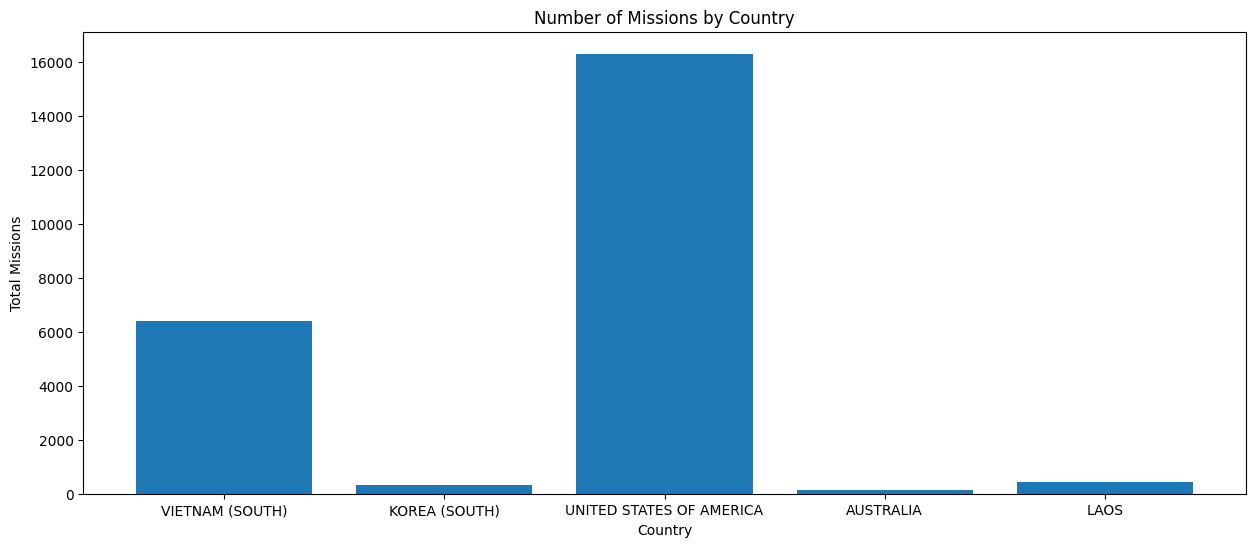

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
missions_pandas = missions_by_country.toPandas()

plt.figure(figsize=(15, 6))
plt.bar(missions_pandas['ContryFlyingMission'], missions_pandas['count'])
plt.title('Number of Missions by Country')
plt.xlabel('Country')
plt.ylabel('Total Missions')
plt.show()


Question 3:

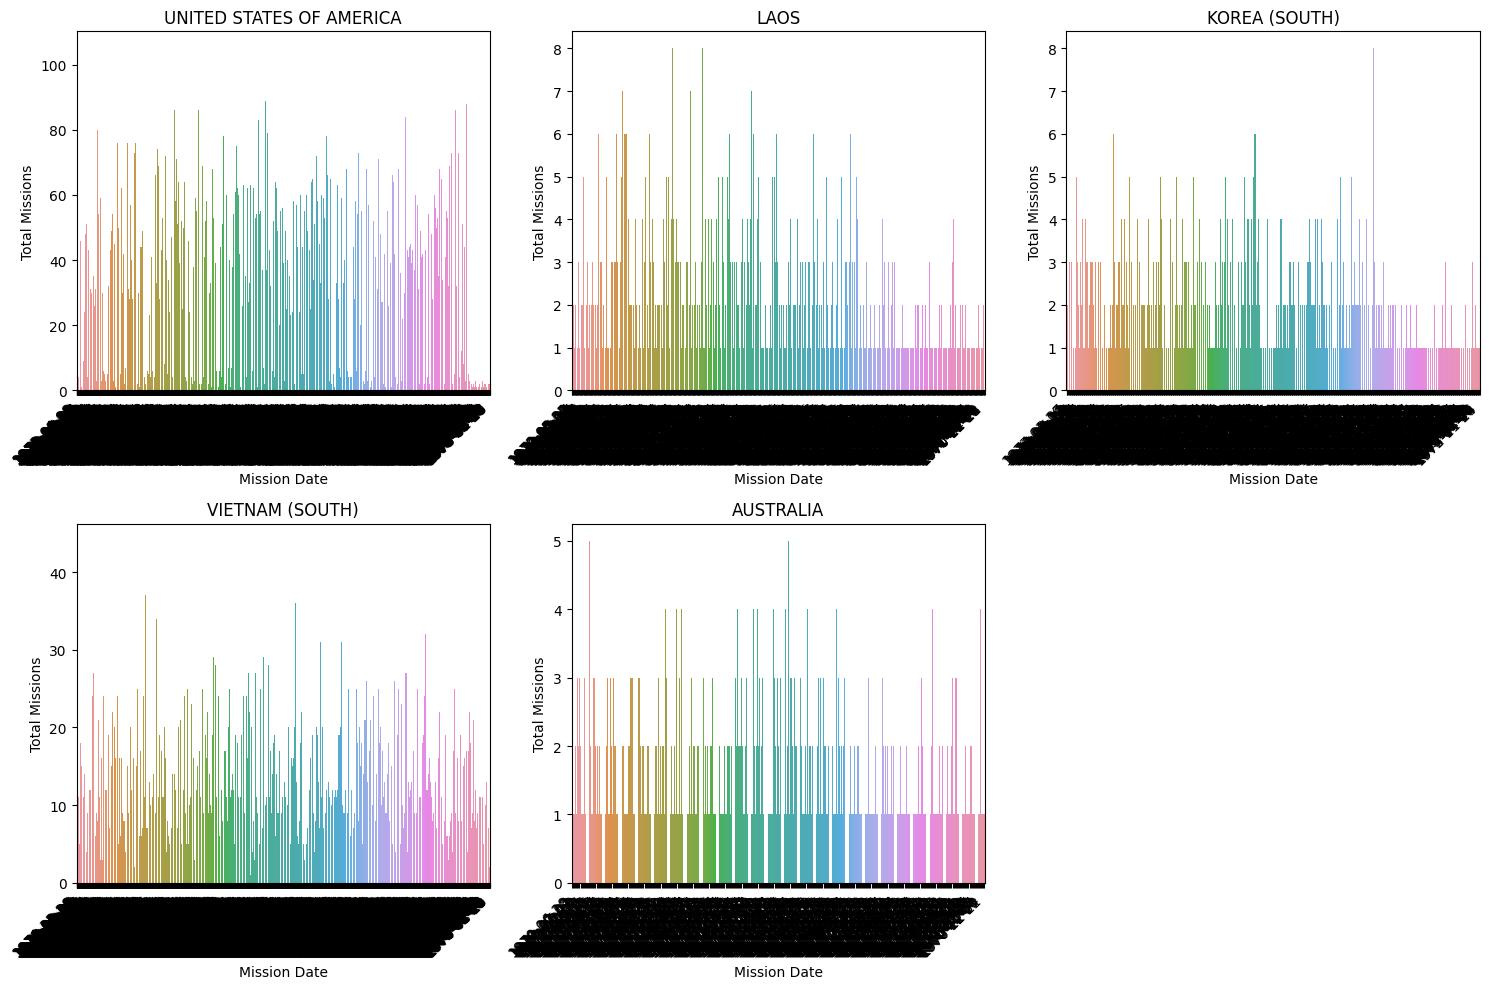

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
df_bombing_operations = spark.read.json('Bombing_Operations.json')
df_bombing_operations.createOrReplaceTempView("bombing_operations")

query = """
    SELECT ContryFlyingMission, MissionDate, COUNT(*) as TotalMissions
    FROM bombing_operations
    GROUP BY ContryFlyingMission, MissionDate
"""

missions_per_day = spark.sql(query)

missions_per_day_pandas = missions_per_day.toPandas()

plt.figure(figsize=(15, 10))

countries = missions_per_day_pandas['ContryFlyingMission'].unique()
for i, country in enumerate(countries, start=1):
    plt.subplot(2, 3, i)
    country_data = missions_per_day_pandas[missions_per_day_pandas['ContryFlyingMission'] == country]
    sns.barplot(x='MissionDate', y='TotalMissions', data=country_data)
    plt.title(f'{country}')
    plt.xlabel('Mission Date')
    plt.ylabel('Total Missions')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()



Question 4:

In [ ]:
df_bombing_operations = spark.read.json('Bombing_Operations.json')
df_bombing_operations.createOrReplaceTempView("bombing_operations")

query = """
        SELECT TakeoffLocation, COUNT(*) as num_missions
        FROM bombing_operations
        WHERE MissionDate = "1966-06-29"
        GROUP BY TakeoffLocation
"""

sql_df = spark.sql(query)
sql_df.show()

+-----------------+------------+
|  TakeoffLocation|num_missions|
+-----------------+------------+
|          CHU LAI|          71|
|     CAM RANH BAY|          35|
|     TAN SON NHUT|         145|
|        NHA TRANG|          16|
|        PHAN RANG|          14|
|           DANANG|         129|
|         UDORN AB|          65|
| HANCOCK (CVA-19)|          46|
|    CONSTELLATION|          87|
|           TAKHLI|          59|
|        BINH THUY|          18|
|           RANGER|          37|
|           PLEIKU|          35|
|            KORAT|          61|
|         BIEN HOA|         112|
|          UBON AB|          48|
|ORISKANY (CVA-34)|           4|
|          CUBI PT|           1|
+-----------------+------------+



Question 5:

In [23]:
#I did it this way because all of the non-null operations had a WeaponsLoadedWeight of -1, so I decided to consider the operations with
#the heaviest bombings are those with the most missions flown
df_bombing_operations = spark.read.json('Bombing_Operations.json')
df_bombing_operations = df_bombing_operations.filter(col('OperationSupported').isNotNull())
missions_by_country = df_bombing_operations.groupBy('OperationSupported').count()
missions_by_country = missions_by_country.orderBy('count', ascending = False)
missions_by_country.show(5)

+--------------------+------+
|  OperationSupported| count|
+--------------------+------+
|          IN COUNTRY|546215|
|IN COUNTRY - SOUT...|200616|
|ROLLING THUN - RO...|197400|
|        ROLLING THUN|196026|
|         STEEL TIGER|127572|
+--------------------+------+
only showing top 5 rows



Question 6:

In [ ]:
df_bombing_operations = spark.read.json('Bombing_Operations.json')
df_bombing_operations.createOrReplaceTempView("bombing_operations")

query = """
        WITH monthly_missions as (
          SELECT month(MissionDate) as Month, COUNT(*) as num_missions
          FROM bombing_operations
          GROUP BY Month
          )

      SELECT Month
      FROM monthly_missions
      ORDER BY num_missions DESC
      LIMIT 1
"""

sql_df = spark.sql(query)
sql_df.show()

+-----+
|Month|
+-----+
|    5|
+-----+



Question 7:

In [ ]:
df_bombing_operations = spark.read.json('Bombing_Operations.json')
df_aircraft = spark.read.json('Aircraft_Glossary.json')


df_missions_aircraft = df_bombing_operations.join(df_aircraft, df_bombing_operations['AirCraft'] == df_aircraft['AirCraft'])

df_missions_aircraft = df_missions_aircraft.groupBy('AirCraftType').count()


df_missions_aircraft = df_missions_aircraft.orderBy(col('count').desc())

df_missions_aircraft.show(1)

+------------------+-------+
|      AirCraftType|  count|
+------------------+-------+
|Fighter Jet Bomber|1073126|
+------------------+-------+
only showing top 1 row

